# EA Gauge Data Quality Analysis Template

This notebook analyzes the quality of EA gauge data to:
1. Identify suitable periods for model training/validation
2. Understand temporal patterns in data quality
3. Quantify data reliability
4. Guide data preprocessing decisions

The analysis includes:
- Quality flag distribution
- Temporal patterns (hourly/daily/monthly)
- Continuous quality streaks (useful for identifying stable periods)
- Quality-annotated time series visualization

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set working directory
os.chdir('/Users/antonfreidin/water_project/')

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 20

# Define consistent color scheme for quality flags
QUALITY_COLORS = {
    'Good': '#00A878',       # Professional green - trustworthy, reliable
    'Suspect': '#FF595E',    # Soft red - warning without being harsh
    'Missing': '#1E88E5',    # Professional blue - neutral, informative
    'Error': '#FFC107',      # Muted amber - attention-grabbing but not jarring
    'Unchecked': '#7E57C2',  # Refined purple - neutral status
    'Estimated': '#FF8F00'   # Deep orange - cautionary but not negative
}

In [2]:
def load_ea_gauge_data(station_name: str) -> pd.DataFrame:
    """Load EA gauge data.
    
    Args:
        station_name: Name of the station (e.g., 'Bodmin-St-Petrocs-Well')
        
    Returns:
        DataFrame with all columns including quality flags
    """
    data_path = Path('data/river_data/ea_gauge_data')
    file_name = f"{station_name}-level-15min-Qualified.csv"
    
    df = pd.read_csv(
        data_path / file_name,
        parse_dates=['dateTime']
    )
    
    return df

def analyze_quality_distribution(df: pd.DataFrame) -> dict:
    """Analyze distribution of quality flags."""
    quality_stats = {
        'total_records': len(df),
        'quality_counts': df['quality'].value_counts().to_dict(),
        'quality_percentage': (df['quality'].value_counts(normalize=True) * 100).to_dict()
    }
    return quality_stats

def plot_quality_distribution(df: pd.DataFrame):
    """Create pie chart and bar plot of quality distribution with consistent colors."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    quality_counts = df['quality'].value_counts()
    
    # Get colors for each quality type
    colors = [QUALITY_COLORS.get(q, '#95A5A6') for q in quality_counts.index]
    
    # Pie chart
    wedges, texts, autotexts = ax1.pie(
        quality_counts.values,
        labels=quality_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        pctdistance=0.85
    )
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=10)
    ax1.set_title('Quality Distribution (Pie Chart)', pad=20)
    
    # Bar plot
    bars = ax2.bar(quality_counts.index, quality_counts.values, color=colors)
    ax2.set_title('Quality Distribution (Bar Plot)', pad=20)
    ax2.set_ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def analyze_temporal_patterns(df: pd.DataFrame) -> dict:
    """Analyze quality patterns by hour, day, and month."""
    df = df.copy()
    df['hour'] = df['dateTime'].dt.hour
    df['day_of_week'] = df['dateTime'].dt.dayofweek
    df['month'] = df['dateTime'].dt.month
    
    patterns = {
        'hourly': df.pivot_table(
            values='value',
            index='hour',
            columns='quality',
            aggfunc='count'
        ).fillna(0),
        'daily': df.pivot_table(
            values='value',
            index='day_of_week',
            columns='quality',
            aggfunc='count'
        ).fillna(0),
        'monthly': df.pivot_table(
            values='value',
            index='month',
            columns='quality',
            aggfunc='count'
        ).fillna(0)
    }
    return patterns

def plot_temporal_patterns(patterns: dict):
    """Plot quality patterns by hour, day, and month with consistent colors."""
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    
    # Get colors for each quality type
    colors = [QUALITY_COLORS.get(q, '#95A5A6') for q in patterns['hourly'].columns]
    
    # Hourly patterns
    patterns['hourly'].plot(kind='bar', stacked=True, ax=axes[0], color=colors)
    axes[0].set_title('Quality Distribution by Hour of Day', pad=20)
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('Number of Records')
    axes[0].legend(title='Quality Flags', bbox_to_anchor=(1.05, 1))
    
    # Daily patterns
    patterns['daily'].plot(kind='bar', stacked=True, ax=axes[1], color=colors)
    axes[1].set_title('Quality Distribution by Day of Week', pad=20)
    axes[1].set_xlabel('Day (0=Monday, 6=Sunday)')
    axes[1].set_ylabel('Number of Records')
    axes[1].legend(title='Quality Flags', bbox_to_anchor=(1.05, 1))
    
    # Monthly patterns
    patterns['monthly'].plot(kind='bar', stacked=True, ax=axes[2], color=colors)
    axes[2].set_title('Quality Distribution by Month', pad=20)
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Number of Records')
    axes[2].legend(title='Quality Flags', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

def analyze_quality_streaks(df: pd.DataFrame) -> dict:
    """Analyze continuous streaks of each quality type.
    
    This is particularly useful for identifying stable periods for model training/validation.
    """
    streaks = {}
    for quality in df['quality'].unique():
        # Find streaks
        mask = df['quality'] == quality
        streak_groups = mask.ne(mask.shift()).cumsum()[mask]
        
        if not streak_groups.empty:
            streak_counts = streak_groups.value_counts()
            longest_streak = streak_counts.max() * 15  # Convert to minutes
            avg_streak = streak_counts.mean() * 15
            streaks[quality] = {
                'longest_streak_minutes': longest_streak,
                'avg_streak_minutes': avg_streak,
                'streak_distribution': streak_counts.value_counts().to_dict()
            }
    
    return streaks

def plot_quality_over_time(df: pd.DataFrame):
    """Plot river levels colored by quality flag with consistent colors."""
    plt.figure(figsize=(15, 7))
    
    # Plot each quality type separately for better control over colors
    for quality in df['quality'].unique():
        mask = df['quality'] == quality
        color = QUALITY_COLORS.get(quality, '#95A5A6')
        
        plt.scatter(
            df.loc[mask, 'dateTime'],
            df.loc[mask, 'value'],
            c=[color],
            label=quality,
            alpha=0.7,
            s=2
            
        )
    
    plt.title('River Level Measurements by Quality Over Time', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Level (m)')
    
    # Enhanced legend
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        title='Quality Flags',
        title_fontsize=11,
        frameon=True,
        edgecolor='black',
        markerscale=10
    )
    
    plt.tight_layout()
    plt.show()

def find_best_training_periods(df: pd.DataFrame, min_length_days: int = 30) -> pd.DataFrame:
    """Find continuous periods of 'Good' data suitable for model training.
    
    Args:
        df: DataFrame with quality flags
        min_length_days: Minimum length of continuous good data (default: 30 days)
        
    Returns:
        DataFrame with start/end dates of good periods
    """
    # Find continuous 'Good' periods
    mask = df['quality'] == 'Good'
    streak_groups = mask.ne(mask.shift()).cumsum()
    
    good_periods = []
    for group in streak_groups[mask].unique():
        period = df[streak_groups == group]
        length_days = (period['dateTime'].max() - period['dateTime'].min()).total_seconds() / (24 * 3600)
        
        if length_days >= min_length_days:
            good_periods.append({
                'start_date': period['dateTime'].min(),
                'end_date': period['dateTime'].max(),
                'length_days': length_days,
                'n_records': len(period)
            })
    
    if not good_periods:
        return pd.DataFrame()
    
    return pd.DataFrame(good_periods).sort_values('length_days', ascending=False)

## Load and Analyze Data

/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_85092/3626115616.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Data Quality Analysis:
Total Records: 947,110

Quality Distribution:
Good: 576,332 (60.9%)
Suspect: 243,127 (25.7%)
Unchecked: 112,893 (11.9%)
Estimated: 14,711 (1.6%)
Missing: 47 (0.0%)


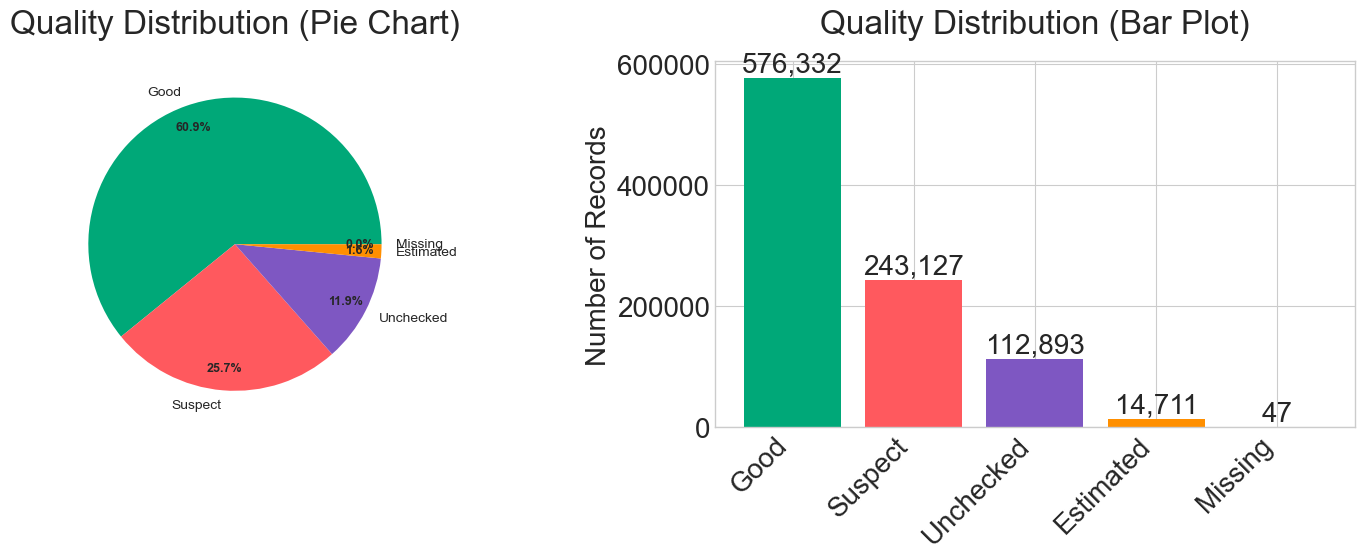

In [4]:
# Load data
station_name = 'woolstone-mill'  # Replace with your station
df = load_ea_gauge_data(station_name)

# Basic quality distribution
quality_stats = analyze_quality_distribution(df)
print("Data Quality Analysis:")
print(f"Total Records: {quality_stats['total_records']:,}")
print("\nQuality Distribution:")
for quality, count in quality_stats['quality_counts'].items():
    percentage = quality_stats['quality_percentage'][quality]
    print(f"{quality}: {count:,} ({percentage:.1f}%)")

# Plot quality distribution
plot_quality_distribution(df)

## Temporal Pattern Analysis

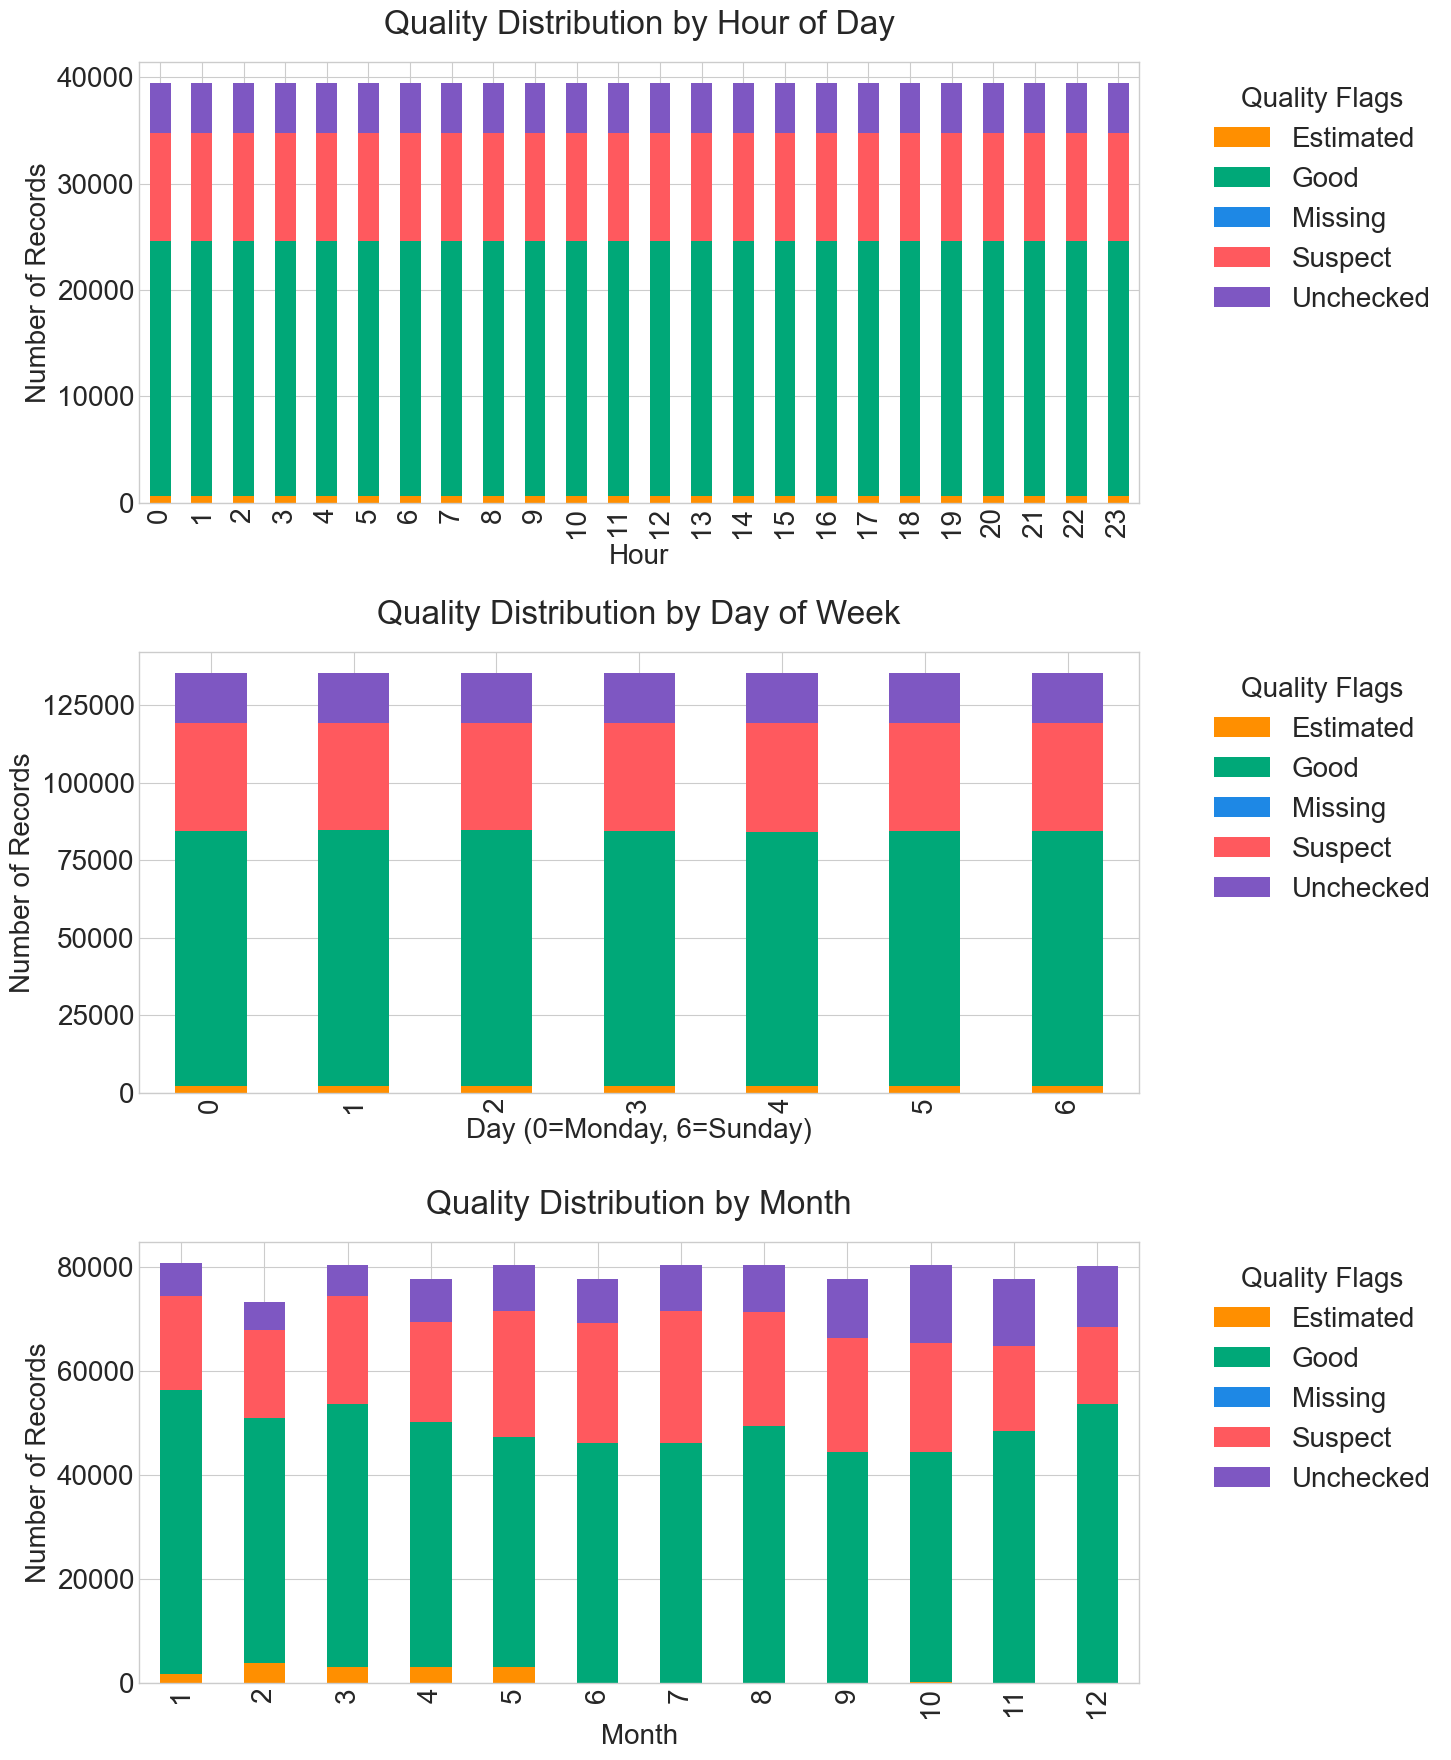

In [6]:
# Analyze temporal patterns
patterns = analyze_temporal_patterns(df)
plot_temporal_patterns(patterns)

## Quality Streak Analysis

This analysis helps identify continuous periods of consistent data quality, which is crucial for:
1. Selecting training/validation periods
2. Understanding data reliability
3. Planning data preprocessing strategies

In [7]:
# Analyze quality streaks
streaks = analyze_quality_streaks(df)

print("Quality Streak Analysis:")
for quality, stats in streaks.items():
    print(f"\n{quality}:")
    print(f"Longest streak: {stats['longest_streak_minutes']/60/24:.1f} days")
    print(f"Average streak: {stats['avg_streak_minutes']/60:.1f} hours")

Quality Streak Analysis:

Suspect:
Longest streak: 1280.0 days
Average streak: 4052.1 hours

Good:
Longest streak: 1460.2 days
Average streak: 4502.6 hours

Estimated:
Longest streak: 132.6 days
Average streak: 282.9 hours

Unchecked:
Longest streak: 738.4 days
Average streak: 2822.3 hours

Missing:
Longest streak: 0.3 days
Average streak: 2.4 hours


## Time Series Quality Visualization

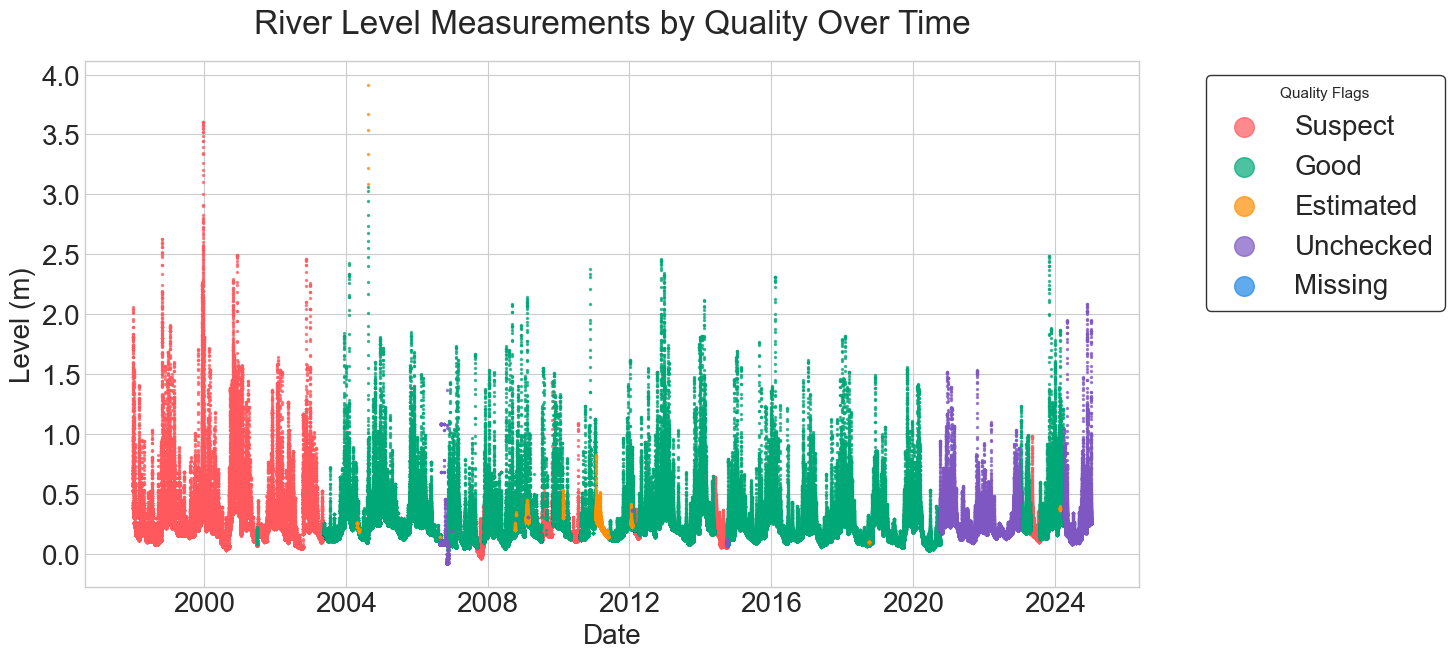

In [10]:
# Plot quality over time
plot_quality_over_time(df)

## Find Best Training Periods

Identify continuous periods of 'Good' data suitable for model training/validation.

In [11]:
# Find periods with at least 30 days of continuous good data
good_periods = find_best_training_periods(df, min_length_days=30)

if not good_periods.empty:
    print("Found the following periods of continuous good data:")
    for _, period in good_periods.iterrows():
        print(f"\nPeriod: {period['start_date'].strftime('%Y-%m-%d')} to {period['end_date'].strftime('%Y-%m-%d')}")
        print(f"Length: {period['length_days']:.1f} days")
        print(f"Number of records: {period['n_records']:,}")
else:
    print("No continuous periods of good data found meeting the minimum length requirement.")

Found the following periods of continuous good data:

Period: 2014-10-04 to 2018-10-03
Length: 1460.2 days
Number of records: 140,181

Period: 2012-04-09 to 2014-05-20
Length: 771.0 days
Number of records: 74,019

Period: 2018-10-04 to 2020-10-01
Length: 727.9 days
Number of records: 69,883

Period: 2004-08-16 to 2006-01-12
Length: 513.6 days
Number of records: 49,311

Period: 2003-05-23 to 2004-04-26
Length: 339.5 days
Number of records: 32,593

Period: 2007-11-20 to 2008-10-05
Length: 320.4 days
Number of records: 30,762

Period: 2006-12-21 to 2007-09-13
Length: 265.8 days
Number of records: 25,515

Period: 2011-05-30 to 2012-01-19
Length: 234.4 days
Number of records: 22,506

Period: 2006-01-13 to 2006-08-24
Length: 222.4 days
Number of records: 21,350

Period: 2023-07-25 to 2024-02-20
Length: 210.0 days
Number of records: 20,160

Period: 2010-08-13 to 2011-01-17
Length: 157.0 days
Number of records: 15,076

Period: 2009-02-18 to 2009-07-07
Length: 138.7 days
Number of records: 13,3

## Quality Analysis Summary

Based on the analysis above, we can make the following observations:
1. Quality Distribution: [Your observations about the distribution of quality flags]
2. Temporal Patterns: [Your observations about any time-based patterns]
3. Quality Streaks: [Your observations about continuous periods of good/bad data]

### Recommendations for Modeling:
1. Data Filtering: [Recommendations for which quality flags to include/exclude]
2. Training Periods: [Recommendations for optimal training periods]
3. Preprocessing: [Any specific preprocessing needed based on quality patterns]